# MGT 595 Problem Set 8
# November 2, 2020

This problem set relates to initial tests of market efficiency that focuses largely on the relation between past returns and expected returns, seasonality in returns, and the dangers and cautions of data mining. In order to proceed you need Microsoft Excel and file “Problem_Set8.xls”. This file contains returns on 75 portfolios sorted on size and various lengths of past returns (1-month, 12-month, and 60-month past returns). In addition, the file contains monthly returns to the Fama and French factors, including a proxy for the excess return on the market portfolio, RMRF, plus the T-bill returns.



## Data Processing

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import f
import scipy.stats
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#--------------------Read subsheet 1--------------------
sheet1_p1=pd.read_excel("Problem_Set8.xls", sheet_name='125 Size-Past return portfolios', 
                     skiprows=8, index_col=None, usecols="A:Z", na_values=-999)
sheet1_p1["Date"] = pd.to_datetime(sheet1_p1["Past 1-month return"], format="%Y%m")
p1_return = sheet1_p1.set_index("Date")
p1_return = p1_return.loc[p1_return.index.dropna()]
p1_return = p1_return.drop("Past 1-month return", axis = 1)

sheet1_p212=pd.read_excel("Problem_Set8.xls", sheet_name='125 Size-Past return portfolios', 
                     skiprows=8, index_col=None, usecols="AA:AZ", na_values=-999)
sheet1_p212["Date"] = pd.to_datetime(sheet1_p212["Past 2-12-month return"], format="%Y%m")
p212_return = sheet1_p212.set_index("Date")
p212_return = p212_return.loc[p212_return.index.dropna()]
p212_return = p212_return.drop("Past 2-12-month return", axis = 1)

sheet1_p1360=pd.read_excel("Problem_Set8.xls", sheet_name='125 Size-Past return portfolios', 
                     skiprows=8, index_col=None, usecols="BA:BZ", na_values=-999)
sheet1_p1360["Date"] = pd.to_datetime(sheet1_p1360["Past 13-60-month return"], format="%Y%m")
p1360_return = sheet1_p1360.set_index("Date")
p1360_return = p1360_return.loc[p1360_return.index.dropna()]
p1360_return = p1360_return.drop("Past 13-60-month return", axis = 1)

# All 75 returns
all_return = pd.concat([p1_return, p212_return, p1360_return], axis=1)

#--------------------Read subsheet 2--------------------
sheet2=pd.read_excel("Problem_Set8.xls", sheet_name='FF factors', 
                     skiprows=0, index_col=None, na_values=-999)
sheet2["Date"] = pd.to_datetime(sheet2["Unnamed: 0"], format="%Y%m")
factors = sheet2.set_index("Date")
factors = factors.loc[factors.index.dropna()]
factors = factors.drop("Unnamed: 0", axis = 1)

# Excess returns
# Note that the 75 returns (sheet 1 data) are from 1926-02 to 2015-07,
# FF factors (sheet 2 data) are form 1926-07 to 2015-11. To do vector-wise 
# subtraction, we only take the dates that two datasets overlap, i.e. 1926-07 - 2015-07.
all_return_excess = pd.DataFrame()
for i, idx in enumerate(all_return.columns):
  all_return_excess[idx] = all_return.iloc[5:,i] - factors["RF"][:1069]


## a)	Estimate the January mean return for each of the 75 size-and-past-return based portfolios. Compare January mean return to mean return February through December. The easiest way to do this is to run a regression of the excess (of the T-bill return) portfolio return on an intercept and a January dummy variable (e.g., a variable which equals 1 if the month is January and zero otherwise). The dummy variable coefficient gives the January specific “extra” mean return. Is there a strong January seasonal that is different than other months? For which portfolios is this largest or smallest?  Why might this be?

We have $$\text{Excess return} = \beta_0 + \beta_1 \mathbb{1}_{Jan} \text{ where } \mathbb{1}_{Jan} = \begin{cases}
      1, & \text{if the month is January} \\
      0, & \text{otherwise}
    \end{cases}.$$

Then
$$\text{Mean excess return} = \beta_0 + \beta_1 \text{ for January and }$$

$$\text{Mean excess return} = \beta_0 \text{ for February through December. }$$

Therefore, the "extra" mean return, or January effect, is $(\beta_0 + \beta_1) - \beta_0 =  \beta_1$ and we use $\beta_1$ to determine the January seasonal effect. 

In [3]:
# Create January dummy variable
jan_date = all_return_excess[all_return_excess.index.month==1].index
all_return_excess['jan_dummy'] = [1 if x in jan_date else 0 for x in all_return_excess.index]

In [4]:
# Table 1
beta0 = []
beta1 = []
p_value_beta0 = []
p_value_beta1 = []

for i in all_return_excess.iloc[:,0:75].columns:
  x = sm.add_constant(all_return_excess['jan_dummy']) 
  mod1 = sm.OLS(all_return_excess[i], x, missing='drop').fit()
  beta0.append(mod1.params[0]) 
  beta1.append(mod1.params[1])
  p_value_beta0.append(mod1.pvalues[0]) 
  p_value_beta1.append(mod1.pvalues[1])

result1 = np.column_stack((beta0, beta1, p_value_beta0,p_value_beta1))
result1 = pd.DataFrame(result1)
result1.index = all_return_excess.iloc[:,0:75].columns
result1.columns = ["beta0", "beta1", "p_value_beta0", "p_value_beta1"]
result1['beta0 + beta1'] = result1['beta0'] + result1['beta1'] # January mean excess return = beta0 + beta1
result1

,beta0,beta1,p_value_beta0,p_value_beta1,beta0 + beta1
Low,1.434612,8.407298,0.000031,2.621966e-12,9.841910
2,0.765092,5.816481,0.011985,4.231758e-08,6.581573
3,0.653490,4.925724,0.024981,1.208368e-06,5.579213
4,0.369214,4.613595,0.199808,4.195092e-06,4.982809
High,-0.426092,4.052833,0.143967,6.410291e-05,3.626742
...,...,...,...,...,...
Low.14,-1.423323,1.524499,0.004562,3.784512e-01,0.101176
2.14,0.648237,0.909528,0.002882,2.254236e-01,1.557765
3.14,0.666935,0.399417,0.000344,5.337571e-01,1.066353
4.14,0.706280,-0.119221,0.000106,8.492461e-01,0.587059


In [5]:
print("average beta0 =", round(np.mean(result1['beta0'],),2), "average beta1 =", round(np.mean(result1['beta1']),2))

# Compute combined p-values to make sure the result is significant
_, combined_p_value_beta0 = scipy.stats.combine_pvalues(p_value_beta0, method='fisher', weights=None)
_, combined_p_value_beta1 = scipy.stats.combine_pvalues(p_value_beta1, method='fisher', weights=None)
print("Using Fisher's method, we compute the combined p-values, which p-value for beta0 =", \
      round(combined_p_value_beta0,2), "and p-value for beta1 =", round(combined_p_value_beta1,2))

average beta0 = 0.68 average beta1 = 2.51
Using Fisher's method, we compute the combined p-values, which p-value for beta0 = 0.0 and p-value for beta1 = 0.0


In [6]:
# Table 2
jan_effect = np.column_stack((result1['beta1'][0:25], result1['beta1'][25:50], result1['beta1'][50:75]))
jan_effect = pd.DataFrame(jan_effect)
jan_effect.index = result1['beta1'][0:25].index
jan_effect.columns = ["past 1 mo return", "past 2-12 mo return", "past 13-60 mo return"]
jan_effect.style.set_caption("January effect (value of beta1)")

,past 1 mo return,past 2-12 mo return,past 13-60 mo return
Low,8.407298,8.509522,8.330421
2,5.816481,6.313289,5.577421
3,4.925724,5.202608,4.151889
4,4.613595,4.330271,4.195224
High,4.052833,4.121503,3.498719
Low.1,4.637822,4.822847,4.983297
2.1,3.596280,3.788793,3.416562
3.1,2.824023,2.865659,2.542273
4.1,2.615414,2.231426,1.985359
High.1,1.972412,2.011873,1.985889


- Estimated January mean return = $\beta_0 + \beta_1$ for each of the 75 returns is reported in Table 1.

- To compare January mean return to mean return February through December, we looked at $\beta_1$. From the averge $\beta_1$, there is a strong January seasonal that is different than other months.

- From Table 2, the small size & low past 2-12 month return portfolio has the largest January seasonal effect. The big size & high past 2-12 month return portfolio has the smallest January seasonal effect.

- We can see the trend that the largest January effect is among small-size & low past return portfolios while the smallest January effect is among big-size & high past return portfolios. 

There could be different reasons as to why there is a January effect:

- Financially, the January effect could be due to tax planning reason. Since capital gain tax is applied to for the capital gain within the calendar year, investors may sell off stocks (that are at a loss) by the end of the year (December) and buy them back in January to hold and hope for gain in the upcoming years. Therefore, since December may see a dumping of the stock, its price could generally see a loss, and since January may see a hot pursuit for holding, its price could generally see a gain, and therefore the unusually high gain by the January effect.

- Behaviorally, the January effect could also be due to higher earning expectation of the 4th quarter. For certain sectors such as consumer and retail, the holiday season usually provides a higher earning, and therefore with such expectation investors may choose to invest in these stocks to get better return when the 4th quarter results are announced. This, however, could not necessarily explain the movement of the entire market, as these sectors such as consumer and retail are only a small portion of it.

## b)	Do the same as above for December by adding a December dummy variable as well to the regression (and still include the January dummy) and then compare the mean return in December to the mean return February through November (which is the intercept) to the mean return in January for the portfolios.  Is there a strong December and January seasonal that is different than other months and different from each other?  For which portfolios are these seasonalities largest or smallest?  Can you conjecture why these differences exist?


We have $$\text{Excess return} = \beta_0 + \beta_1 \mathbb{1}_{Jan} + \beta_2 \mathbb{1}_{Dec}.$$

In [7]:
# Create December dummy variable
dec_date = all_return_excess[all_return_excess.index.month==12].index
all_return_excess['dec_dummy'] = [1 if x in dec_date else 0 for x in all_return_excess.index]

In [8]:
beta0 = []
beta1 = []
beta2 = []
p_value_beta0 = []
p_value_beta1 = []
p_value_beta2 = []

for i in all_return_excess.iloc[:,0:75].columns:
  x = sm.add_constant(all_return_excess[['jan_dummy','dec_dummy']]) 
  mod2 = sm.OLS(all_return_excess[i], x, missing='drop').fit()
  beta0.append(mod2.params[0]) 
  beta1.append(mod2.params[1])
  beta2.append(mod2.params[2])
  p_value_beta0.append(mod2.pvalues[0]) 
  p_value_beta1.append(mod2.pvalues[1])
  p_value_beta2.append(mod2.pvalues[2])

# Table 3
result2 = np.column_stack((beta0, beta1, beta2, p_value_beta0, p_value_beta1, p_value_beta2))
result2 = pd.DataFrame(result2)
result2.index = all_return_excess.iloc[:,0:75].columns
result2.columns = ["beta0", "beta1", "beta2", "p_value_beta0", "p_value_beta1", "p_value_beta2"]
result2

,beta0,beta1,beta2,p_value_beta0,p_value_beta1,p_value_beta2
Low,1.464815,8.377095,-0.332568,0.000050,3.896619e-12,0.780483
2,0.765028,5.816545,0.000702,0.016630,4.868127e-08,0.999471
3,0.680011,4.899202,-0.292034,0.026194,1.535180e-06,0.773294
4,0.418249,4.564560,-0.539935,0.166265,5.818081e-06,0.590061
High,-0.414916,4.041657,-0.123062,0.175045,7.246352e-05,0.903479
...,...,...,...,...,...,...
Low.14,-1.591466,1.692642,1.861585,0.002492,3.301169e-01,0.286747
2.14,0.548582,1.009183,1.103323,0.016016,1.802025e-01,0.145071
3.14,0.603688,0.462665,0.700241,0.001981,4.728329e-01,0.279920
4.14,0.627482,-0.040423,0.872399,0.001002,9.488013e-01,0.168292


In [9]:
print("average beta0 =", round(np.mean(result2['beta0'],),2), "average beta1 =", \
      round(np.mean(result2['beta1']),2), "average beta2 =", round(np.mean(result2['beta2']),2))

# Compute combined p-values to make sure the result is significant
_, combined_p_value_beta0 = scipy.stats.combine_pvalues(p_value_beta0, method='fisher', weights=None)
_, combined_p_value_beta1 = scipy.stats.combine_pvalues(p_value_beta1, method='fisher', weights=None)
_, combined_p_value_beta2 = scipy.stats.combine_pvalues(p_value_beta2, method='fisher', weights=None)

print("Using Fisher's method, we compute the combined p-values, which p-value for beta0 =", \
      round(combined_p_value_beta0,2), ", p-value for beta1 =", round(combined_p_value_beta1,2), \
      ", p-value for beta2 =", round(combined_p_value_beta2,2))

average beta0 = 0.61 average beta1 = 2.58 average beta2 = 0.77
Using Fisher's method, we compute the combined p-values, which p-value for beta0 = 0.0 , p-value for beta1 = 0.0 , p-value for beta2 = 0.0


In [10]:
# Table 4
jan_effect2 = np.column_stack((result2['beta1'][0:25], result2['beta1'][25:50], result2['beta1'][50:75]))
jan_effect2 = pd.DataFrame(jan_effect2)
jan_effect2.index = result2['beta1'][0:25].index
jan_effect2.columns = ["past 1 mo return", "past 2-12 mo return", "past 13-60 mo return"]
jan_effect2.style.set_caption("January effect (value of beta1)")

,past 1 mo return,past 2-12 mo return,past 13-60 mo return
Low,8.377095,8.402719,8.305528
2,5.816545,6.266891,5.584013
3,4.899202,5.155648,4.174779
4,4.564560,4.340652,4.193407
High,4.041657,4.218613,3.459448
Low.1,4.708637,4.806068,5.059509
2.1,3.672384,3.827932,3.512497
3.1,2.895390,2.953008,2.641403
4.1,2.715101,2.362708,2.057973
High.1,2.071407,2.156090,2.047976


In [11]:
# Table 5
dec_effect = np.column_stack((result2['beta2'][0:25], result2['beta2'][25:50], result2['beta2'][50:75]))
dec_effect = pd.DataFrame(dec_effect)
dec_effect.index = result2['beta2'][0:25].index
dec_effect.columns = ["past 1 mo return", "past 2-12 mo return", "past 13-60 mo return"]
dec_effect.style.set_caption("December effect (value of beta2)")

,past 1 mo return,past 2-12 mo return,past 13-60 mo return
Low,-0.332568,-1.182108,-0.275594
2,0.000702,-0.513550,0.072986
3,-0.292034,-0.519762,0.253430
4,-0.539935,0.114892,-0.020112
High,-0.123062,1.074832,-0.434787
Low.1,0.779760,-0.185711,0.843781
2.1,0.838002,0.433195,1.062133
3.1,0.785839,0.966800,1.097513
4.1,1.097686,1.453051,0.803940
High.1,1.090059,1.596216,0.687388


- From the mean estimates and p-values, There is a strong January and December seasonal comparing with Feb-Nov. January effect is stronger from December effect because on average $\beta_1>\beta_2$ and the individual p-values are larger for $\beta_2$ than ones for $\beta_1$

- From Table 4, the small size & low past 2-12 month return portfolio has the largest January seasonal effect. The big size & high past 2-12 month return portfolio has the smallest January seasonal effect.

- From Table 5, the small size & low past 2-12 month return portfolio has the largest December seasonal effect. The size 4 & high past 2-12 month return portfolio has the smallest December seasonal effect.

Similar to above, taxation may explain the December and January effect. We can see that the return is higher in January, meaning that there may be unusual amount of investors buying in January, which coincide with the tax effect. This hypothesis, however, seems to have a difficult time explaining the December effect, which seems to have a higher return in general (higher $\beta_2$) than February - November (lower $\beta_0$).

## c)	Are these findings evidence for or against market efficiency? How would you try to reconcile the above findings with the efficient markets hypothesis? How are the findings perhaps a violation of efficient markets? (hint: consider statistical explanations, transaction costs, the model we have assumed, etc.)



(DW - There are arguments to be made for these findings to be evidence both for and against market efficiency. For one, if we believe the taxation consideration is true and the reason that results in the December and January effect, these would be evidence against market efficiency. This is because the taxation is purely a friction in the market, and therefore the underlying cashflows of the assets should not change. Consequently, the prices of the assets, determined by the cashflows of the assets, should be unchanged. However, the observation shows the opposite, where the price is altered due to friction in the market.

In contrast, we could also say that for investors, the actual cashflows generated for them need to take into account the tax effect, and therefore it is an evidence for market efficiency that the December and January effect exist. Although, an argument against such proposition is that, the strategy of trading out on December and back in on January has transaction costs associated to it, and therefore on average the profit of doing so should move towrads zero, indicating that such strategy should not be empoyed.)

## d)	Now, let’s look at the relation between past returns and expected returns. Run a series of cross-sectional regressions in the style of Fama and MacBeth (1973) where the left-hand-side of the regression is the return of each of the 75 portfolios in month t in excess of the risk-free rate in month t on the following right-hand-side variables:

i)	The past one-month return of each portfolio (e.g., return on the portfolio in month t-1)

ii)	The past 12-month return of each portfolio, skipping the most recent month (e.g., cumulative return on the portfolio from month t-2 to t-12)

iii)	The past 60-month return of each portfolio, skipping the most recent year (e.g., cumulative return on the portfolio from month t-13 to t-60)

Run this cross-section regression every month, save the coefficients, and then report the time-series average of the coefficients over all months as well as the time-series t-statistics on those coefficients in the style of Fama and MacBeth (1973). Comment on the coefficients on the lagged returns of each portfolio.  What pattern of predictability do they indicate?  What is the relation between past returns and average returns?  Does this violate some form of market efficiency?  Why might it?  What else could explain these patterns?

Step 1: $\text{Excess Return} = \beta_0 + \beta_1R_{1mo} + \beta_2R_{12mo} + \beta_3R_{60mo} \text{ for 1069 time periods}$ 

Step 2:  $\text{Excess Return} = \gamma_0 + \gamma_1\beta_1 + \gamma_2\beta_2 + \gamma_3\beta_3 \text{ for 75 portfolios}$ 

In [12]:
all_return_excess = all_return_excess.drop(labels=['jan_dummy','dec_dummy'], axis=1)

In [13]:
%%time
R1mo = np.zeros(all_return_excess.shape)
R12mo = np.zeros(all_return_excess.shape)
R60mo = np.zeros(all_return_excess.shape)
for i in range(61,all_return_excess.shape[0]):
  R1mo[i,:] = np.sum(all_return_excess.iloc[i-1,:])
  R12mo[i,:] = np.sum(all_return_excess.iloc[i-12:i-2,:])
  R60mo[i,:] = np.sum(all_return_excess.iloc[i-60:i-13,:])

CPU times: user 1.71 s, sys: 4.51 ms, total: 1.72 s
Wall time: 1.72 s


In [14]:
R1mo = pd.DataFrame(R1mo)
R12mo = pd.DataFrame(R12mo)
R60mo = pd.DataFrame(R60mo)

R1mo = R1mo.set_index(all_return_excess.index)
R12mo = R12mo.set_index(all_return_excess.index)
R60mo = R60mo.set_index(all_return_excess.index)

R1mo.columns = all_return_excess.columns
R12mo.columns = all_return_excess.columns
R60mo.columns = all_return_excess.columns

In [15]:
# First step of Fama-Macbeth
betas = []
all_return_excess['constant'] = [1]*1069
for i in range(all_return_excess.shape[0]):
  x = pd.concat([R1mo.iloc[i,:], R12mo.iloc[i,:],R60mo.iloc[i,:]], axis=1)
  x.loc['constant'] = [1,1,1]
  mod3 = sm.OLS(all_return_excess.iloc[i,:], x, missing='drop').fit()
  betas.append(mod3.params) 

In [16]:
df = pd.DataFrame(np.array(betas).reshape(1069,3))
df.columns = ['beta1', 'beta2','beta3']
df

,beta1,beta2,beta3
0,0.333333,0.333333,0.333333
1,0.333333,0.333333,0.333333
2,0.333333,0.333333,0.333333
3,0.333333,0.333333,0.333333
4,0.333333,0.333333,0.333333
...,...,...,...
1064,-0.015224,0.014248,0.109817
1065,0.458194,-0.085479,-0.159652
1066,0.470325,0.038720,0.117002
1067,-0.037491,0.111205,0.027836


In [17]:
print("beta1 = ", round(np.mean(df['beta1']), 2), "beta2 = ", round(np.mean(df['beta2']), 2),"beta3 = ", round(np.mean(df['beta3']), 2))

beta1 =  0.02 beta2 =  0.04 beta3 =  0.03


In [18]:
all_return_excess = all_return_excess.drop('constant', axis =1)

In [19]:
# Second step of Fama-Macbeth
gammas = []
for i in range(all_return_excess.shape[1]):
  x = sm.add_constant(df[['beta1', 'beta2','beta3']])
  mod4 = sm.OLS(list(all_return_excess.iloc[:,i]), x , missing='drop').fit()
  gammas.append(mod4.params) 

In [20]:
df2 = pd.DataFrame(np.array(gammas).reshape(75,4))
df2.columns = ['gamma0','gamma1', 'gamma2','gamma3']
df2

,gamma0,gamma1,gamma2,gamma3
0,2.048191,0.230463,4.601827,-4.052024
1,1.296692,0.351248,3.907301,-8.284023
2,1.094368,0.053589,2.690687,-5.472053
3,0.752029,0.544269,3.877284,-6.504240
4,0.013277,0.480454,2.927690,-8.987793
...,...,...,...,...
70,0.341063,-1.722477,-23.570495,-113.131968
71,0.632410,0.660705,2.989873,1.594614
72,0.636146,0.591799,2.459126,0.048299
73,0.616013,0.385603,1.717589,3.877786


In [21]:
print("gamma0 = ", round(np.mean(df2['gamma0']), 2), "gamma1 = ", round(np.mean(df2['gamma1']), 2), "gamma2 = ", round(np.mean(df2['gamma2']), 2),"gamma3 = ", round(np.mean(df2['gamma3']), 2))

gamma0 =  0.89 gamma1 =  0.63 gamma2 =  1.71 gamma3 =  -2.5


From the risk premium above, we can see that both the 1-month return factor and the 2-12 month return factor provide positive return with higher magnitude for 2-12 month, while the 3-60 month factor provide negative return with the highest absolute magnitude among the three. This may seem to violate the market efficiency, as 

## e)	Now, let’s put together all of the information. Create a strategy that best exploits all of the facts found above. For example, this might entail going long small stocks and past 12-month losing stocks in January, and short large stocks and past 12-month winning stocks in January, doing the reverse in Dec., doing the opposite for 60-month winners and losers, etc. Try to maximize the Sharpe ratio of your portfolio based on the information you learned from the regressions above. Once you have created this strategy, compute its time-series mean, standard deviation, and Sharpe ratio.

From what we got from earlier parts of the question, there are January and December seasonality effects. Moreover, from the risk premium coefficient, the 12-month return are in the positive direction and the effect is more than 1-month. Therefore, to maximize the Sharpe ratio of our portfolio, assuming that we could only hold one position at a time, we should short 12-month winning small stocks (Low) in December, Long 12-month winning small stocks (Low) in January. Specifically, short the smallest 12-month winning small stocks in December with $\beta_2$ = -1.18, and long the winning 12-month winning stocks in January with $\beta_1$ = 8.40.


## f) .Compute the confidence interval around the Shape ratio you calculated in e.
The Sharpe ratio is approximately distributed under a normal distribution:
$$
S R \sim N\left(\frac{\mu}{\sigma}, \frac{1}{T-1}\left(1+\frac{\mu^{2}}{2 \sigma^{2}}\right)\right)
$$
The Sharpe ratio is approximately distributed under more general conditions:
$$
\begin{array}{l}S R \sim N\left(S R, \frac{1}{T-1}\left(1+\frac{S R^{2}}{4}\left[\frac{\mu_{4}}{\sigma^{4}}-1\right]-S R \frac{\mu_{3}}{\sigma^{3}}\right)\right) \\ \mu_{k}=E\left[\left(r_{t}-\bar{r}\right)^{k}\right] \\ S R \sim N\left(S R, \frac{1}{T-1}\left(1+\frac{S R^{2}}{4}[k u r t-1]-S R^{*} \text { skew }\right)\right)\end{array}
$$
Please compute the confidence intervals of your Sharpe ratio under both the normal and more general distributions.



## g)	Now let’s generate some random strategies. We have 75 size-past-return-based portfolios. Each month, randomly select a portfolio from the 75 size-past-return portfolios, and use its return as our random strategy return. (To do this, generate a random integer between 1 and 75, and use the portfolio corresponding to the random integer.) Do this each month and you have generated a time-series of returns to a random strategy.

•	Then, repeat this process of producing a random strategy 5,000 times so that you get 5,000 time-series of different random strategies.  

•	A useful function in Matlab is R = ceil(75.*rand(N,M)) where R equals an NxM matrix of random numbers between 1 and 75.

•	Compute the mean, standard deviation, and Sharpe ratio for each of these random strategies.

•	What fraction of these random strategies exhibit returns that are statistically different from zero?

•	Plot the 5,000 t-stats of the mean returns to these strategies in a histogram and comment on the number of t-stats greater than 2 or less than –2.  For the strategies that produced t-stats greater than 2 or less than –2, does this mean we have found a strategy that delivers performance?

•	What fraction of these random strategies exhibit Sharpe ratios that are larger than the strategy you created in part e)?

•	What fraction of these random strategies exhibit Sharpe ratios that are larger than the upper part of the confidence intervals you calculated in f)?

•	Bonus question:  Under the normal distribution, how probable are the max and min returns to your strategy in part e) (e.g., what is the probability you would see a return at least as high as the max or as low as the min) assuming 
a.	the backtested Sharpe ratio was the true Sharpe ratio?
b.	the full range of confidence interval around the Sharpe ratio is possible?

What danger does your answer to these last set of questions highlight in empirical work?


Text(0.5, 1.0, 'Part g): Frequency of Different T-Statistics for 5000 Simulations')

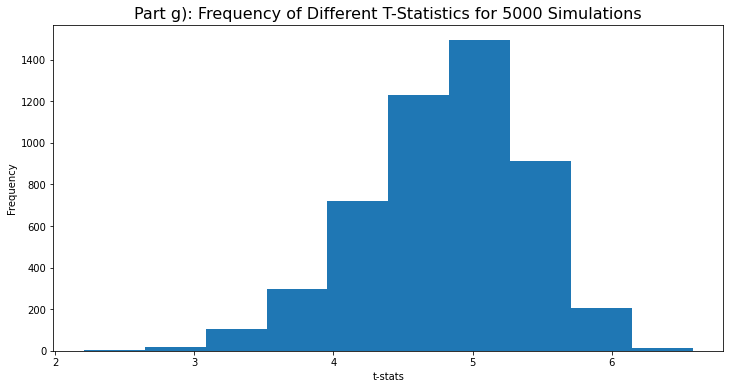

In [22]:
M = 5000
N = 1073
values = np.ceil(np.random.rand(M, N) * 74)
mean = []
tstat = []
stddev = []
sharpe = []
RF = np.mean(factors['RF'])

for i in range(M):
    temp = np.zeros(N)
    for j in range(N):
        column_idx = int(values[i,j])
        temp[j] = all_return.iloc[j, column_idx]
    mean_temp = np.nanmean(temp)
    mean.append(mean_temp)
    stddev_temp = np.nanstd(temp)
    stddev.append(stddev_temp)
    stderr_temp = stddev_temp / np.sqrt(N)
    tstat.append(mean_temp / stderr_temp)
    sharpe_temp = (np.nanmean(temp) - RF) / np.nanstd(temp)
    sharpe.append(sharpe_temp)

fig=plt.figure(figsize=(12,6))
plt.hist(tstat)
plt.xlabel('t-stats')
plt.ylabel('Frequency')
plt.title('Part g): Frequency of Different T-Statistics for 5000 Simulations', fontsize=16)

We can see the histogram of the t-stats for the 5000 simulations above, which shows that pretty much all random strategies portfolios provide returns that are statistically different from zero.

That notwithstanding, although the strategies produce portfolios with overshelmingly high t-stats, we know from our construction that rationale of the strategy itself is pure randomness, and therefore it doesn't mean we have found a strategy that delivers performance.

Text(0.5, 1.0, 'Part g): Frequency of Different Sharpe Ratios for 5000 Simulations')

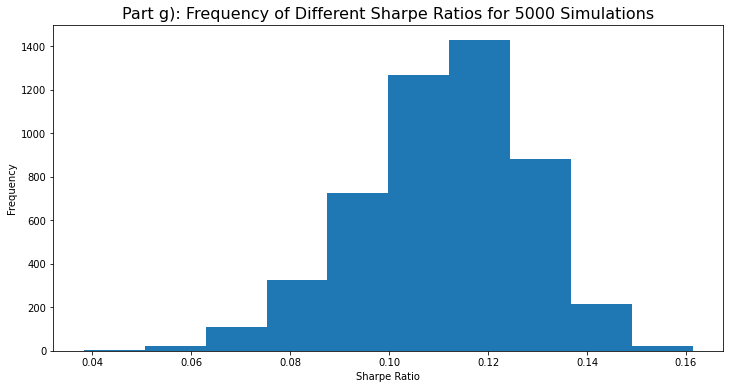

In [23]:
fig=plt.figure(figsize=(12,6))
plt.hist(sharpe)
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frequency')
plt.title('Part g): Frequency of Different Sharpe Ratios for 5000 Simulations', fontsize=16)

We could see that, empirically, there could be many way to construct a strategy that seems to work - provide higher return than normal with statistical significance. However, from the above exercises, we can see that having high return and high statistical significance is not sufficient to prove that there is a working strategy - while a working strategy necessarily has high return with statistical significance, the opposite is not true.

In that sense, mining past datas to try to find a strategy that works could lead to dangerously appealing result. We see that simply randomly select assets provide good return with high statistical significance, yet there's no basis, either from the efficient market hypothesis or more behavioral standpoint, for such random strategy to work. Therefore, we need to be caution when a strategy seems to work and examine whether the basis of its construction makes sense. 